In [1]:
from PIL import Image
from scipy import ndimage
from scipy import misc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from os import path

#TODO use k-d tree for faster look-up times
'''
loads into a nd-array all images from the given directory

raises exceptions if the path is not a directory or it doesn't exist

dir_path -> path to the directory that contains images

returns -> images
images -> nd-array (numpy) with the images
'''
def load_images (dir_path) :
    p = Path(dir_path)
    
    if not p.exists() :
        raise FileNotFoundError
        
    if not p.is_dir() :
        raise NotADirectoryError
    
    files = [str(x) for x in p.iterdir() if not x.is_dir()]
    
    images = [ndimage.imread(path) for path in files]
    images = np.array(images)
    
    return images

In [3]:
#TODO what do when the source is grayscale and the tiles are RGB
'''
creates an empty mosaic "canvas" on which the tiles will be placed

the dimensions are based on the specified horizontal tile count, the dimensions
of the source image and the tiles

the canvas will be sized so as no tiles are cut off

htcount  -> how many tiles wide should the mosaic be
simg     -> the source image
tshape   -> the dimensions of the tiles (height, width, channels)

returns -> htiles, vtiles, canvas
htiles, vtiles -> the size of the mosaic in number of tiles
canvas         -> the original image resized to the mosaic shape
'''
def mosaic_shape (htcount, simg, tshape) :
    if type(htcount) != int :
        raise TypeError('htcount not an int')
    if htcount < 0 :
        raise ValueError('htcount negative integer')
    if type(tshape) != tuple :
        raise TypeError('tshape not a tuple')
    if type(simg) != np.ndarray :
        raise TypeError('source image not a ndarray')
    
    imheight = simg.shape[0]
    imwidth = simg.shape[1]
    aspect_ratio = imheight / imwidth
    
    theight = tshape[0] 
    twidth = tshape[1]
        
    canvasw = htcount * twidth;
    canvash = aspect_ratio * canvasw
    canvash = round(canvash / theight) * theight # closest multiple of theight
    
    vtcount = canvash / theight
    
    canvas = misc.imresize(simg, (canvash, canvasw))
    
    htiles = htcount
    vtiles = vtcount
    
    return int(htiles), int(vtiles), canvas

280 400
10 10
28 40


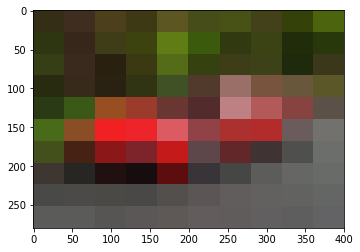

In [50]:
'''
computes the average color / intensity of the image

image -> source image

returns -> mean
mean -> the average color/intesity (either a tuple of size 3 or a constant)
'''
def immean (image) :
    if type(image) != np.ndarray :
        raise TypeError('image is not ndarray')
    
    rank = len(image.shape)
    
    if rank < 3 :
        mean = int(round(np.mean(image)))
    else :
        mean = []
        for band in range(3) : 
            mean_for_band = int(round(np.mean(image[:,:,band])))
            mean.append(mean_for_band)
    
    return mean


im = ndimage.imread('./data/imaginiTest/ferrari.jpeg')
tile = ndimage.imread('./data/colectie/1.png')
htiles, vtiles, canvas = mosaic_shape(10, im, tile.shape)

imheight = canvas.shape[0]
imwidth = canvas.shape[1]

clip_width = tile.shape[1]
clip_height = tile.shape[0]

print(imheight, imwidth)
print(vtiles, htiles)
print(clip_height, clip_width)

for i in range(vtiles) :
    for j in range(htiles) :
        start_vslice = i * clip_height
        end_vslice = start_vslice + clip_height
        vslice = slice(start_vslice, end_vslice)
        
        start_hslice = j * clip_width
        end_hslice = start_hslice + clip_width
        hslice = slice(start_hslice, end_hslice)
        
        imclip = canvas[vslice, hslice]
        
        clip_mean = immean(imclip)
        
        for band in range(3) : 
            imclip[:,:,band] = clip_mean[band]
    
plt.imshow(canvas)
plt.show()

In [45]:
im = tile
mean = immean(im)
b = np.empty(im.shape)
for i in range(3) :
    b[:,:,i] = mean[i]
print(mean)

[96, 94, 96]
